# <center>+++ Project is currently in progress ;-) +++<center>

# Generative Model classification for handwritten digits

In this notebook I will build a **generative model classifier** to classify the handwritten digits from the MNIST dataset. The results will be compared with the k-Nearest-Neighbor classifier for the MNIST dataset from my other project. 

# 1. Set up the notebook and load the data

Just like I did with the k-Nearest-Neighbour classifier for the MNIST dataset, I'll be working with a subset of the data. The complete dataset consists of 60,000 and 10,000 training and test images respectively. The subset contains 7,500 training images and 1,000 test images.

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [39]:
# Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

# Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [40]:
# Print out the dimensions of the datasets
print('Training data set dimensions: {}'.format(np.shape(train_data)))
print('Number of training data labels: {}'.format(len(train_labels)))
print('Test data set dimensions: {}'.format(np.shape(test_data)))
print('Number of test data labels: {}'.format(len(test_labels)))

Training data set dimensions: (7500, 784)
Number of training data labels: 7500
Test data set dimensions: (1000, 784)
Number of test data labels: 1000


Let's see whether within the training and test images each number is equally represented.

In [41]:
train_digits, train_counts = np.unique(train_labels, return_counts=True)
dict_train_distribution = dict(zip(train_digits, train_counts))
print('train digit \tcounts')
[print('{} \t\t{}'.format(i, dict_train_distribution.get(i))) for i in list(train_digits)]

test_digits, test_counts = np.unique(test_labels, return_counts=True)
dict_test_distribution = dict(zip(test_digits, test_counts))
print('\ntest digit \tcounts')
[print('{} \t\t{}'.format(i, dict_test_distribution.get(i))) for i in list(test_digits)];

train digit 	counts
0 		750
1 		750
2 		750
3 		750
4 		750
5 		750
6 		750
7 		750
8 		750
9 		750

test digit 	counts
0 		100
1 		100
2 		100
3 		100
4 		100
5 		100
6 		100
7 		100
8 		100
9 		100


# 2. Visualizing the data

Each data point is stored as a 784-dimensional vector. To visualize a data point, let's first reshape it to a 28x28 image.

In [49]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    #plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train", prediction=None):
#def vis_image(index, dataset="train"):    
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    if prediction!=None: print('Predicted Label ' + str(prediction))
    return

## View the first data point in the training set
#vis_image(0, "train")

## Now view the first data point in the test set
#vis_image(0, "test")

# 3. Fit a Gaussian generative model to the training data

* pi[j] 10x1
* mu[j] 10x784
* sigma[j] 10x784x784

In order to calculate the density distributions the inverse of the covariance matrix is needed. As many of the covariance matrices are singular or close to singular it's important to regularize these matrices. This is done by adding a regularization term cI where c is a constant and I is the identity matrix. 

In [6]:
def fit_generative_model(x, y, c):
    k = 10
    d = (x.shape)[1]
    pi = np.zeros(k)
    mu = np.zeros((k, d))
    sigma = np.zeros((k,d,d))
    
    for label in range(k):
        indices = (y == label)
        pi[label] = float(sum(indices)/len(y))
        mu[label] = np.mean(x[indices], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1) + np.identity(d)*c
    return pi, mu, sigma

In [10]:
# Compute log Pr(label|image) for each [test image, label] pair
def predict(testx, testy, pi_test, mu_test, sigma_test, c):
    k = 10
    score = np.zeros((len(testy), k))
    for testpoint in range(len(testy)):
        #print('# Testpoint: {}'.format(testpoint))
        for label in range(k):
            score[testpoint, label] = np.log(pi_test[label]) + \
                multivariate_normal.logpdf(testx[testpoint], mean=mu_test[label,:], cov=sigma_test[label,:,:])
    predictions = np.argmax(score, axis=1)
    accuracy_rate = np.sum(predictions == testy)/len(testy)
    #print('Accuracy rate: {}'.format(accuracy_rate))
    return accuracy_rate, predictions

## 3.1 k-fold cross validation to determine constant c:

To find the constant c that yields the best results, cross validation is applied on the training data for different values for c. In this case k was chosen to k=3. As the running time for the cross validation is very long, it was conducted in a separate file. The following pseudo code shows the routine: 

*for c in c_values:
    <br> $\;\;\;\;\;\;$ for i in range(k):
    <br> $\;\;\;\;\;\;\;\;\;\;\;\;$ training_set = ith chunk of training data of size k
    <br> $\;\;\;\;\;\;\;\;\;\;\;\;$ validation_set = {training data - training_set}
    <br> $\;\;\;\;\;\;\;\;\;\;\;\;$ fit generative model to training_set
    <br> $\;\;\;\;\;\;\;\;\;\;\;\;$ calculate accuracy of model using validation_set
    <br> $\;\;\;\;\;\;$ calculate mean accuracy from the k runs for current value c*
        
The following accuracies were obtained from the cross-validation for certain values of c:

In [11]:
column_names = ['c value', 'accuracy for run 1', 'accuracy for run 2', 'accuracy for run 3']
df = pd.DataFrame(columns = column_names)
data = pd.DataFrame({'c value': [1000, 10000, 100000], 
                     'accuracy for run 1': [0.952, 0.951, 0.839], 
                     'accuracy for run 2': [0.943, 0.941, 0.843], 
                     'accuracy for run 3': [0.941, 0.942, 0.842]})
df = df.append(data)
df.set_index('c value', inplace=True)
df['mean'] = df.mean(axis=1)
df.head()

,accuracy for run 1,accuracy for run 2,accuracy for run 3,mean
c value,,,,
1000,0.952,0.943,0.941,0.945333
10000,0.951,0.941,0.942,0.944667
100000,0.839,0.843,0.842,0.841333


A value of c=1000 is chosen to train the final model, as it yields the highest accuracies on the training data. 

# 4. Make predictions on data set

In [12]:
pi_final, mu_final, sigma_final = fit_generative_model(train_data, train_labels, 1000)
accuracy_rate, predictions = predict(test_data, test_labels, pi_final, mu_final, sigma_final, 1000)

In [13]:
print('Accuracy rate achieved on the test data: {}'.format(accuracy_rate))

Accuracy rate achieved on the test data: 0.949


In order to understand where the strength and weaknesses of the model are a confusion matrix is calculated. 

In [16]:
cm = metrics.confusion_matrix(test_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

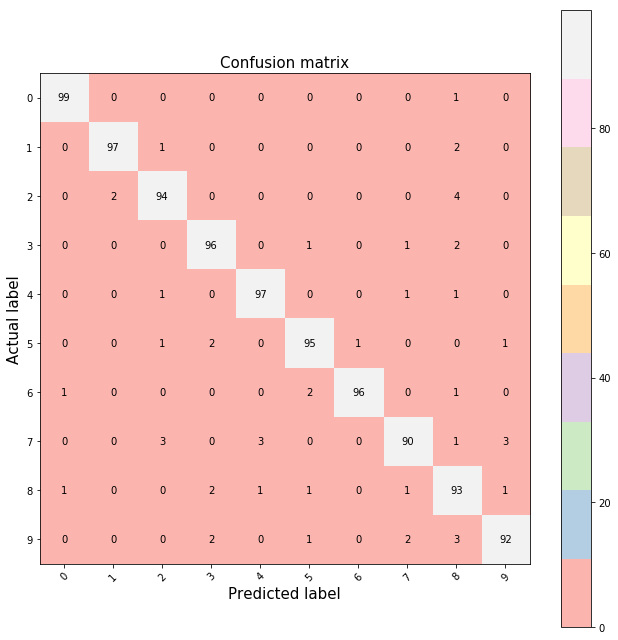

In [18]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

In [61]:
dict_false_predictions = {}
for i in range(10):
    dict_false_predictions[i] = len(np.where((predictions == i) & (predictions != test_labels))[0])
print('prediction \tcount mistakes')
[print('{} \t\t{}'.format(i, dict_false_predictions.get(i))) for i in list(dict_false_predictions.keys())];

prediction 	count mistakes
0 		2
1 		2
2 		6
3 		6
4 		4
5 		5
6 		1
7 		5
8 		15
9 		5


Most errors occur when the label '8' is predicted. Let's have a look at an example of a false '8' prediction:

In [53]:
indices_false_8 = np.where((predictions == 8) & (predictions != test_labels))[0]
indices_false_8

array([ 47,  60, 132, 137, 138, 300, 319, 338, 362, 425, 437, 717, 758,
       835, 913])

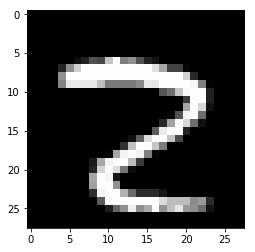

Label 2
Predicted Label 8


In [51]:
vis_image(indices_false_8[0], "test", predictions[indices_false_8[0]])

Let's have a look at a correctly predicted label '8'

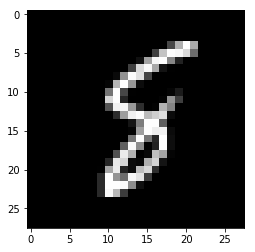

Label 8
Predicted Label 8


In [64]:
indices_correct_8 = np.where((predictions == 8) & (predictions == test_labels))[0]
vis_image(indices_correct_8[0], 'test', predictions[indices_correct_8[0]])

# 5. Conclusion

The overall accuracy rate achieved with the generative model classifier on the MNIST dataset is **94.9%**. Thus the performance of this classifier is slightly poorer than the k-nearest-neighbor classifier from the other project, in which the classifier achieved an accuracy rate of **95.4%**.

(project link: https://github.com/michaelstaden/projects/blob/master/k-Nearest_Neighbor_MNIST.ipynb)